## Sandbox for interacting with the ARASAAC API

In [3]:
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 1.8 MB/s eta 0:00:00 MB/s eta 0:00:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 2.7 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.1/301.1 kB 2.6 MB/s eta 0:00:003.0 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 1.9 MB/s eta 0:00:000:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 2.8 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 2.5 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 2.8 MB/s eta 0:00:00m eta 0:00:010:01:01

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [5]:
import requests
import seaborn as sns
from collections import Counter
import numpy as np
from PIL import Image
from io import BytesIO
#from IPython.display import display, Image, HTML
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

In [6]:
base_url = "https://api.arasaac.org/api"
language = "en"



In [7]:

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [8]:
pd.reset_option('display.max_rows')

In [9]:
# To get a general sense of the categories in ARASAAC
def get_pictos(lang = "en", limit=500):
  url = f'{base_url}/pictograms/all/{lang}'
  response = requests.get(url)
  if response.status_code == 200:
    data = response.json()
    return data[:limit] if limit else data
  else:
    print(f'Error: {response.status_code}')
    return []

def get_keywords(pictograms):
  categories = []
  item_dict = {}
  for pictogram in pictograms:
    if 'categories' in pictogram and pictogram['categories']:
      for category in pictogram['categories']:
        categories.append(category)

        if category not in item_dict:
          item_dict[category] = []

        item_dict[category].append(pictogram['_id'])

  category_counts = Counter(categories)

  df_data = []

  for category, count in category_counts.most_common():
        sample_ids = item_dict[category][:3]
        
        sample_keywords = []
        for pic_id in sample_ids:
            for pic in pictograms:
                if pic["_id"] == pic_id and "keywords" in pic and pic["keywords"]:
                    sample_keywords.append(pic["keywords"][0]["keyword"] 
                                         if pic["keywords"][0]["keyword"] else "Unknown")
                    break
        
        df_data.append({
            "Category": category,
            "Pictogram Count": count,
            "Percentage": round((count / len(pictograms)) * 100, 2),
            "Sample Pictogram IDs": ", ".join(map(str, sample_ids)),
            "Sample Keywords": ", ".join(sample_keywords[:3])
        })
    
  df = pd.DataFrame(df_data)
  return df

print("Fetching pictograms data... (this may take a moment)")
pictograms = get_pictos(language)
print(f"Retrieved {len(pictograms)} pictograms")

categories_df = get_keywords(pictograms)
print("\nCategory Statistics:")
display(categories_df)






Fetching pictograms data... (this may take a moment)
Retrieved 500 pictograms

Category Statistics:


,Category,Pictogram Count,Percentage,Sample Pictogram IDs,Sample Keywords
0,core vocabulary-feeding,41,8.2,"2246, 2281, 2296","olive oil, sandwich, coffee"
1,verb,41,8.2,"2271, 2276, 2286","bathe, drink, erase"
2,core vocabulary-object,37,7.4,"2250, 2258, 2242","pillow, wardrobe, coat"
3,terrestrial animal,37,7.4,"2257, 2254, 2291","squirrel, spider, donkey"
4,core vocabulary-living being,36,7.2,"2254, 2291, 2268","spider, donkey, whale"
...,...,...,...,...,...
206,animal-based food,1,0.2,2720,cut the chicken
207,cosmetic,1,0.2,2747,nail varnish
208,dinosaur,1,0.2,2738,dinosaur
209,extinct being,1,0.2,2738,dinosaur


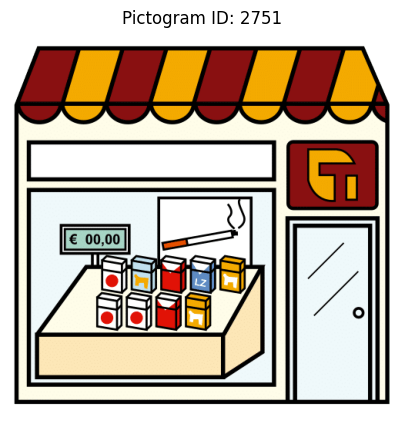

In [10]:
# we can visualize pictograms by passing the id and resolution to the api url
def print_picto(id, resolution=500):
  url = f'https://static.arasaac.org/pictograms/{id}/{id}_{resolution}.png'

  response = requests.get(url)
  if response.status_code == 200:
      img = Image.open(BytesIO(response.content))
      
      plt.figure(figsize=(5, 5))
      plt.imshow(img)
      plt.axis('off')
      plt.title(f"Pictogram ID: {id}")
      plt.show()
  else:
      print(f"Error: Could not retrieve pictogram {id}. Status code: {response.status_code}")

print_picto(2751)


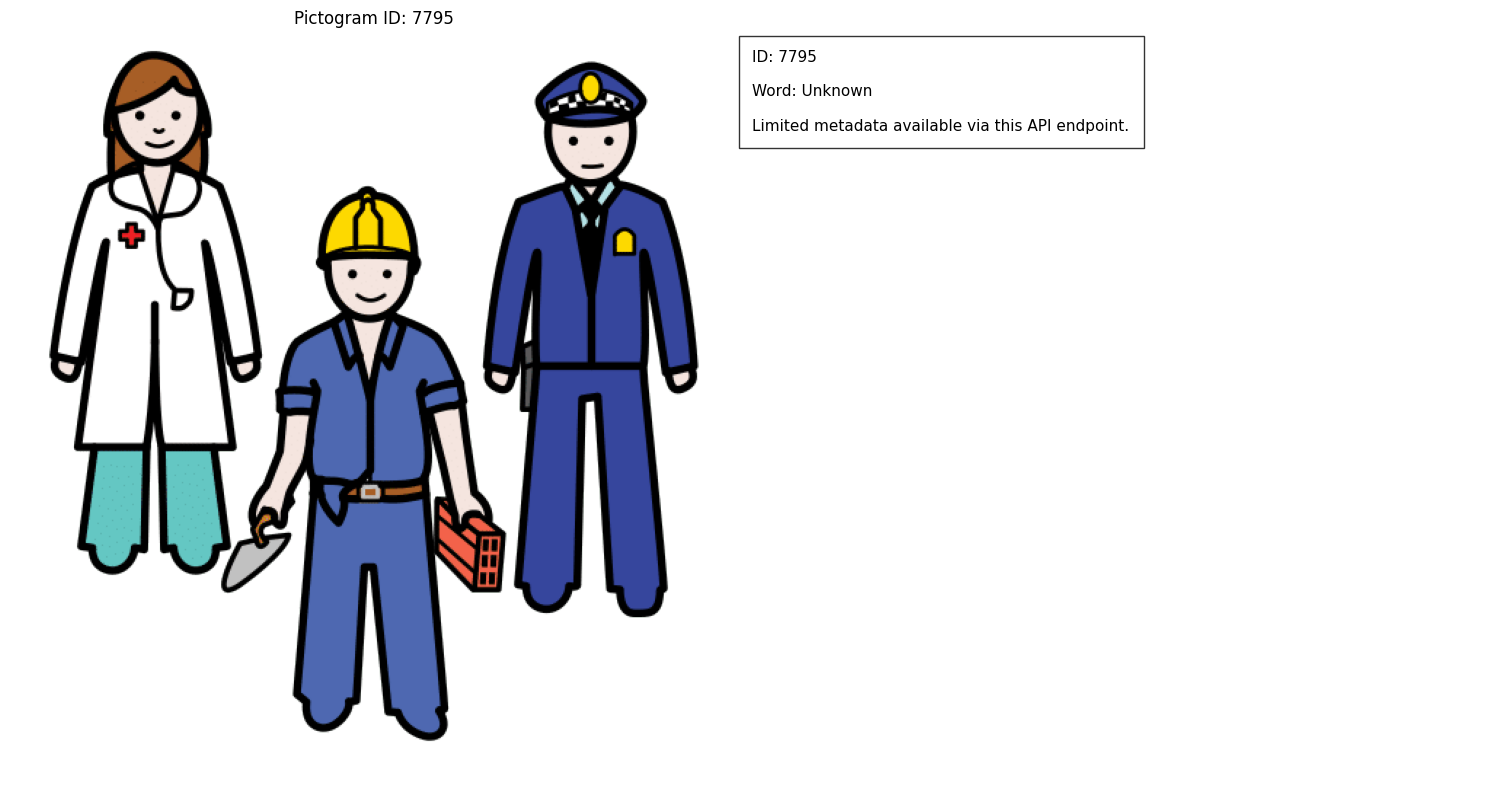

In [20]:
def print_picto_with_metadata(picto_id, resolution=500, language="en"):
    """
    Visualize a pictogram with its extensive metadata.
    
    Parameters:
    - picto_id (int): The ID of the pictogram
    - resolution (int): The desired resolution of the image
    - language (str): Language code for metadata (default: "en")
    """
    # Get the image
    img_url = f'https://static.arasaac.org/pictograms/{picto_id}/{picto_id}_{resolution}.png'
    img_response = requests.get(img_url)
    
    # Try alternative metadata endpoint
    # The direct pictogram endpoint is having issues, let's use the search API instead
    search_url = f"https://api.arasaac.org/api/pictograms/{language}/search/{picto_id}"
    search_response = requests.get(search_url)
    
    if img_response.status_code != 200:
        print(f"Error: Could not retrieve pictogram {picto_id}. Status code: {img_response.status_code}")
        return
    
    # Create a figure with two columns - image on the left, metadata on the right
    fig = plt.figure(figsize=(15, 8))
    
    # Display the image
    ax1 = fig.add_subplot(121)
    img = Image.open(BytesIO(img_response.content))
    ax1.imshow(img)
    ax1.axis('off')
    ax1.set_title(f"Pictogram ID: {picto_id}")
    
    # Display metadata
    ax2 = fig.add_subplot(122)
    ax2.axis('off')
    
    # Default metadata text if API request fails
    metadata_text = f"ID: {picto_id}\nNo additional metadata available."
    metadata = None
    
    try:
        # First try the search API which might find this pictogram
        if search_response.status_code == 200:
            search_results = search_response.json()
            # Find the exact pictogram in search results
            for result in search_results:
                if result.get('_id') == picto_id:
                    metadata = result
                    break
    
        if metadata:
            # Build metadata text
            metadata_text = f"ID: {picto_id}\n\n"
            
            if metadata.get('created'):
                metadata_text += f"Created: {metadata.get('created')}\n"
                
            if 'sex' in metadata:
                metadata_text += f"Sex: {metadata.get('sex')}\n"
                
            if 'schematic' in metadata:
                metadata_text += f"Schematic: {metadata.get('schematic')}\n"
                
            if 'violence' in metadata:
                metadata_text += f"Violence: {metadata.get('violence')}\n"
                
            # Keywords section
            metadata_text += f"\nKeywords ({language}):\n"
            keywords = []
            for kw in metadata.get('keywords', []):
                if isinstance(kw, dict) and 'keyword' in kw:
                    keywords.append(kw['keyword'])
            
            if keywords:
                metadata_text += '\n'.join(f"• {kw}" for kw in keywords)
            else:
                metadata_text += "None available in this language"
                
            # Categories section
            metadata_text += f"\n\nCategories:\n"
            categories = metadata.get('categories', [])
            if categories:
                metadata_text += '\n'.join(f"• {cat}" for cat in categories[:10])
                if len(categories) > 10:
                    metadata_text += f"\n• ... and {len(categories) - 10} more"
            else:
                metadata_text += "None available"
                
            # Tags section
            metadata_text += f"\n\nTags:\n"
            tags = metadata.get('tags', [])
            if tags:
                metadata_text += '\n'.join(f"• {tag}" for tag in tags[:10])
                if len(tags) > 10:
                    metadata_text += f"\n• ... and {len(tags) - 10} more"
            else:
                metadata_text += "None available"
        else:
            # If no results from search API, try to get data from a different endpoint
            word_url = f"https://api.arasaac.org/api/pictograms/{language}/{picto_id}"
            word_response = requests.get(word_url)
            
            if word_response.status_code == 200:
                try:
                    word_data = word_response.json()
                    metadata_text = f"ID: {picto_id}\n\n"
                    metadata_text += f"Word: {word_data.get('keyword', 'Unknown')}\n\n"
                    metadata_text += "Limited metadata available via this API endpoint."
                except:
                    # If JSON decoding fails, use default text
                    pass
    except Exception as e:
        metadata_text += f"\n\nError fetching metadata: {str(e)}"
    
    # Display the metadata
    ax2.text(0, 0.95, metadata_text, va='top', fontsize=11, 
             bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 10})
    
    plt.tight_layout()
    plt.show()
    
    # Return metadata for further use if needed
    return metadata

# Example usage:
print_picto_with_metadata(7795) #12281,7795

In [ ]:
def get_metadata(pictogram_data):

In [ ]:
def print_grid(pico_files, out_file="layout.png", grid=(5, 5)):
  